<a href="https://colab.research.google.com/github/prachimodi-142/ML_Project/blob/main/ML_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prachi Modi
## modi29@purdue.edu 

In [ ]:
# Import necessary libraries
import tensorflow
import sys
import keras
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
from keras.datasets import mnist

# Import Keras layers and models
from keras.layers import Input, Flatten, Dense, Reshape
from keras.layers import Dropout, multiply, BatchNormalization, Embedding, LeakyReLU
from keras.models import Sequential, Model

# Import optimizers
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad

In [ ]:
# Import the drive module from the google.colab package
from google.colab import drive

# Mount the Google Drive filesystem to this Colab instance
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the shape of the input image
image_shape = [28, 28, 1]

# Define the number of classes in the classification task
classes = 10

# Define the dimensionality of the latent space for a generative model
latent_dim = 100

In [ ]:
# Define discriminator model
desc = Sequential([
    Dense(512, input_dim=np.prod(image_shape)), # Input layer with 512 neurons and flattened image shape as input
    LeakyReLU(alpha=0.2), # LeakyReLU activation with alpha = 0.2
    Dense(512), # Hidden layer with 512 neurons
    LeakyReLU(alpha=0.2), # LeakyReLU activation with alpha = 0.2
    Dropout(0.4), # Dropout regularization with rate 0.4
    Dense(512), # Hidden layer with 512 neurons
    LeakyReLU(alpha=0.2), # LeakyReLU activation with alpha = 0.2
    Dropout(0.4), # Dropout regularization with rate 0.4
    Dense(1, activation='sigmoid') # Output layer with sigmoid activation for binary classification
])

# Print summary of discriminator model
desc.summary()

# Define inputs to discriminator model
img = Input(shape=image_shape) # Input layer for image with shape=image_shape
label = Input(shape=(1,)) # Input layer for label with dtype=int32 and shape=(1,)

# Define label embedding layer
label_embedding = Flatten()(Embedding(classes, np.prod(image_shape))(label)) # Embedding layer with input_dim=classes, output_dim=flattened image shape, and flattened label as input
flat_img = Flatten()(img) # Flatten image

# Concatenate image and label embeddings
model_input = multiply([flat_img, label_embedding])

# Generate validity score for concatenated input
validity = desc(model_input)

# Combine inputs and validity score to create discriminator model
desc = Model([img, label], validity)

# Save discriminator model
desc.save("./modelDesc.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0

In [ ]:
# Define the Generator block
gen = Sequential([
    Dense(256, input_dim=latent_dim), # input layer with 256 neurons and the latent_dim input dimension
    LeakyReLU(alpha=0.2), # apply leaky ReLU activation with alpha=0.2
    BatchNormalization(momentum=0.8), # apply batch normalization with momentum=0.8
    Dense(512), # add a hidden layer with 512 neurons
    LeakyReLU(alpha=0.2), # apply leaky ReLU activation with alpha=0.2
    BatchNormalization(momentum=0.8), # apply batch normalization with momentum=0.8
    Dense(1024), # add another hidden layer with 1024 neurons
    LeakyReLU(alpha=0.2), # apply leaky ReLU activation with alpha=0.2
    BatchNormalization(momentum=0.8), # apply batch normalization with momentum=0.8
    Dense(np.prod(image_shape), activation='tanh'), # output layer with np.prod(image_shape) neurons and a tanh activation
    Reshape(image_shape)]) # reshape output to match image shape

# Print the summary of the generator block
gen.summary()

# Save the generator block as a h5 file
gen.save("./modelGen.h5")

# Define input layers for noise and label
result= Input(shape=(latent_dim,)), Input(shape=(1,))
noise=result[0]
label=result[1]

# Embed the label using a dense layer with Flatten activation
label_embedding = Flatten()(Embedding(classes, latent_dim)(label))

# Combine the noise and embedded label using element-wise multiplication
model_input = multiply([noise, label_embedding])

# Generate image from the combined input using the generator block
img = gen(model_input)

# Define the generator model with input layers as noise and label, and output layer as image
gen = Model([noise, label], img)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [ ]:
# Utilizie the Adam optimizer from Keras
optimizer = Adam(0.0002, 0.5)

# compile the discriminator model with binary crossentropy loss,
desc.compile(loss=['binary_crossentropy'],optimizer=optimizer,metrics=['accuracy'])

# set the discriminator as non-trainable (this is done before combining the models)
desc.trainable = False

# create input layers for the noise and label
result = Input(shape=(latent_dim,)), Input(shape=(1,))
noise= result[0]
label= result[1]
# generate an image using the generator model
img = gen([noise, label])

# determine the validity of the generated image using the discriminator
valid = desc([img, label])

# combine the generator and discriminator models into a stacked model
stacked = Model([noise, label], valid)

# compile the stacked model with binary crossentropy loss and the RMSprop optimizer
stacked.compile(loss=['binary_crossentropy'],
    optimizer=optimizer)

# save the stacked model to a file
stacked.save("./modelCombine.h5")

In [ ]:
#Print Generated Images
def genImage(epoch):
    # Create a figure with 2 rows and 5 columns of subplots
    fig, axs = plt.subplots(2, 5)
    # Set the title of the figure
    fig.suptitle("Generated Images")

    # Loop over the rows of subplots
    for i in range(2):
        # Loop over the columns of subplots
        for j in range(5):
            # Sample random noise from a normal distribution
            # with mean 0 and standard deviation 1, and reshape it
            # into a 1x100 array
            noise = np.random.normal(0, 1, (1, 100))
            # Compute the label for the current image as a single
            # integer between 0 and 9, based on the current row and column
            label = np.array([[i*5+j]])
            
            # Generate an image from the noise and label using the GAN generator
            gen_img = gen.predict([noise, label])
            
            # Rescale the image from the range [-1, 1] to the range [0, 1]
            gen_img = (gen_img + 1) / 2.0
            
            # Plot the image and label in the current subplot
            axs[i,j].imshow(gen_img[0,:,:,0], cmap='gray')
            axs[i,j].set_title("Digit: {}".format(label[0,0]))
            axs[i,j].axis('off')

    # Save the figure to a file with a name that includes the current epoch number
    plt.savefig("/content/drive/MyDrive/images/{}.png".format(epoch))
    # Close the figure to free up memory
    plt.close()

In [ ]:
def plot2Fgr(l1,l2, title, name="fig"):
  plt.figure()
  plt.plot(l1, label = "Discriminator Loss")
  plt.plot(l2, label = "Generator Loss")
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title(title)
  plt.legend()
  name=name+'.png'
  plt.savefig(name)
  plt.show()

In [ ]:
def trainer(epochs, batch_size, test_interval):
    # Load the MNIST dataset
    (X_train, y_train), (_, _) = mnist.load_data()

    # Preprocess the input data
    X_train = np.expand_dims((X_train.astype(np.float32) - 127.5) / 127.5, axis=3)
    y_train = y_train.reshape(-1, 1)

    # Define the labels for real and fake images
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    g_loss_array = []
    d_loss_array = []

    for epoch in range(epochs):
        # Select a random batch of images and labels from the dataset
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Sample noise as input for the generator
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate a batch of new images using the generator
        gen_imgs = gen.predict([noise, labels])

        # Train the discriminator using real and fake images
        d_loss_real = desc.train_on_batch([imgs, labels], valid)
        d_loss_fake = desc.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator using the stacked model
        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        g_loss = stacked.train_on_batch([noise, sampled_labels], valid)

        # Print the progress and losses
        print("%d [D Loss: %f, Accuracy.: %.4f%%] [G Loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        g_loss_array.append(g_loss)
        d_loss_array.append(d_loss[0])
    

        # Save generated images at regular intervals
        if epoch % test_interval == 0:
            genImage(epoch)

    plot2Fgr(l1 = d_loss_array, l2 = g_loss_array, title= "Loss Plot")

1/1 [==============================] - 3s 3s/step
0 [D Loss: 0.695423, Accuracy.: 21.8750%] [G Loss: 0.680799]


KeyboardInterrupt: ignored

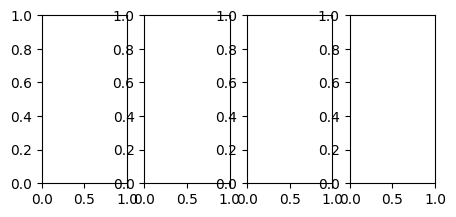

In [ ]:
# The following code initiates the training process with the specified parameters.
trainer(epochs=20000, batch_size=32, test_interval=200)